### Упражнение 7

1. Напишите многослойный перцептрон для решения задачи из соревнования https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/overview. 

2. Подберите метод градиентного спуска из списка SGD, Adam, Momentum (на отложенной выборке) и шаг для этого метода.

3. Подберите значение [дропаута](https://habr.com/ru/company/wunderfund/blog/330814/) и коэффициент L2 регуляризации.

4. Постройте кривые обучения.

Часть 1- подготовка данных, есть чек поинт где можно загрузить подготовленные данные

In [347]:
data_train = pd.read_csv(
    'C:/Users/Евген/Downloads/pkdd-15-predict-taxi-service-trajectory-i/train.csv.zip'
    ,compression='zip')

In [348]:
data_test = pd.read_csv(
    'C:/Users/Евген/Downloads/pkdd-15-predict-taxi-service-trajectory-i/test.csv.zip'
    ,compression='zip')

In [349]:
#посмотрим на количество дубликатов идентефикаторов поездки
data_train['TRIP_ID'].shape[0] - data_train['TRIP_ID'].nunique()

81

In [350]:
#удалим дубликаты
data_train.drop_duplicates(subset='TRIP_ID',inplace=True)

In [351]:
#посмотрим теперь-все в порядке
data_train['TRIP_ID'].value_counts()

1384683034620000186    1
1400171431620000463    1
1374075962620000361    1
1388778783620000039    1
1389820270620000263    1
                      ..
1397476421620000468    1
1397278730620000534    1
1374055651620000247    1
1394648368620000633    1
1403071175620000484    1
Name: TRIP_ID, Length: 1710589, dtype: int64

In [352]:
#теперь TRIP_ID можно удалить
data_train.drop('TRIP_ID', axis = 1, inplace = True)

In [353]:
#посмотрим на распределение CALL_TYPE
type_of_call = data_train['CALL_TYPE'].value_counts()
type_of_call

B    817881
C    527938
A    364770
Name: CALL_TYPE, dtype: int64

In [354]:
#проверим сходится ли количество записей по условию
#CALL_TYPE=А должен быть равен количеству notNaN ORIGIN_CALL  
print(pd.notnull(data_train['ORIGIN_CALL']).sum()==type_of_call['A'])
print(pd.notnull(data_train['ORIGIN_CALL']).sum()-type_of_call['A'])

True
0


In [355]:
#теперь проверим CALL_TYPE=B должен быть равен notNaN ORIGIN_STAND
print(pd.notnull(data_train['ORIGIN_STAND']).sum()==type_of_call['B'])
print(pd.notnull(data_train['ORIGIN_STAND']).sum()-type_of_call['B'])

False
-11302


In [356]:
#разница в 11302 элементах
#удалим эти записи
index_drop_row = data_train.index[(data_train['CALL_TYPE']=='B')\
                               &(data_train['ORIGIN_STAND'].isnull())].tolist()

In [357]:
data_train.drop(index = index_drop_row, inplace=True)

In [358]:
type_of_call = data_train['CALL_TYPE'].value_counts()
type_of_call

B    806579
C    527938
A    364770
Name: CALL_TYPE, dtype: int64

In [359]:
#снова проверим CALL_TYPE=B должен быть равен notNaN ORIGIN_STAND
#теперь все в порядке
print(pd.notnull(data_train['ORIGIN_STAND']).sum()==type_of_call['B'])
print(pd.notnull(data_train['ORIGIN_STAND']).sum()-type_of_call['B'])

True
0


In [360]:
# проверим остальные данные
data_train.isnull().sum()

CALL_TYPE             0
ORIGIN_CALL     1334517
ORIGIN_STAND     892708
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

In [361]:
#объединим ORIGIN_CALL и ORIGIN_STAND
#остальные значения Nan будут принадлежать CALL_TYPE=С
#их заменим нулями
data_train['CALL_AND_STAND'] = data_train[['ORIGIN_CALL','ORIGIN_STAND']].fillna(0).sum(axis=1)

In [362]:
#теперь столбцы ORIGIN_CALL и ORIGIN_STAND
#более не нужны
data_train.drop(['ORIGIN_CALL','ORIGIN_STAND'], axis = 1, inplace = True)

In [363]:
#убедимся что пропусков более нет
data_train.isnull().sum()

CALL_TYPE         0
TAXI_ID           0
TIMESTAMP         0
DAY_TYPE          0
MISSING_DATA      0
POLYLINE          0
CALL_AND_STAND    0
dtype: int64

In [364]:
#посмотрим на признак MISSING_DATA
# True означает, что координаты неполные
data_train['MISSING_DATA'].value_counts()

False    1699277
True          10
Name: MISSING_DATA, dtype: int64

In [365]:
#таких значений 10 
#это небольшое количество, и можно удалить эти строки
index_drop_row = data_train.index[data_train['MISSING_DATA']==True].tolist()

In [366]:
data_train.drop(index = index_drop_row, inplace=True)

In [367]:
#проверим-теперь все в порядке
data_train['MISSING_DATA'].value_counts()

False    1699277
Name: MISSING_DATA, dtype: int64

In [368]:
#избавимся от пустых значений словаря в признаке POLYLINE
index_drop_row = data_train.index[data_train['POLYLINE']=='[]'].tolist()

In [369]:
data_train.drop(index = index_drop_row, inplace=True)

In [370]:
#нумерация индексов нарушена, восстановим
data_train = data_train.reset_index(drop=True)

In [371]:
#создадим новые признаки
#координаты начала поездки
data_train['START_LONGITUDE'] = 0.0
data_train['START_LATITUDE'] = 0.0
#координаты окончания поездки-их будем предсказывать
data_train['FINISH_LONGITUDE'] = 0.0
data_train['FINISH_LATITUDE'] = 0.0
#дистанцию рассчитанную с помощью haversine_distances
data_train['DIST'] = 0.0
#длительность поездки
data_train['TIME_ROAD'] = 0

In [394]:
#определим функции для извлечения данных из POLYLINE
#брать координаты начала и окончания поездки
def return_START_LONGITUDE(i):
    return np.float_(re.findall('[-+]?(?:\d+(?:\.\d*)?|\.\d+)',\
                         data_train.POLYLINE[i]))[0]
def return_START_LATITUDE(i):
    return np.float_(re.findall('[-+]?(?:\d+(?:\.\d*)?|\.\d+)',\
                         data_train.POLYLINE[i]))[1]
def return_FINISH_LONGITUDE(i):
    return np.float_(re.findall('[-+]?(?:\d+(?:\.\d*)?|\.\d+)',\
                         data_train.POLYLINE[i]))[-2]
def return_FINISH_LATITUDE(i):
    return np.float_(re.findall('[-+]?(?:\d+(?:\.\d*)?|\.\d+)',\
                         data_train.POLYLINE[i]))[-1]
#длительность рассчитываем как количество пингов каждые 15 секунд
def return_TIME_ROAD(i):
    return (len(re.findall('\[',data_train.POLYLINE[i]))-1)*15


In [382]:
data_train['START_LONGITUDE'] = [return_START_LONGITUDE(index) \
                                 for index in data_train.index]
data_train['START_LATITUDE'] = [return_START_LATITUDE(index) \
                                for index in data_train.index]
data_train['FINISH_LONGITUDE'] = [return_FINISH_LONGITUDE(index) \
                                  for index in data_train.index]
data_train['FINISH_LATITUDE'] = [return_FINISH_LATITUDE(index) \
                                 for index in data_train.index]

In [397]:
#рассчитываем расстояние
def haversine_dist(index):
    start = []
    finish = []
    start.append(data_train['START_LONGITUDE'][index])
    start.append(data_train['START_LATITUDE'][index])
    finish.append(data_train['FINISH_LONGITUDE'][index])
    finish.append(data_train['FINISH_LATITUDE'][index])
    
    start_in_radians = [radians(_) for _ in start]
    finish_in_radians = [radians(_) for _ in finish]
    result = haversine_distances([start_in_radians, finish_in_radians])
    return result[0][1] * 6371000/1000
data_train['DIST'] = [haversine_dist(index) for index in data_train.index]
data_train['TIME_ROAD'] = [return_TIME_ROAD(index) for index in data_train.index]

In [400]:
#теперь POLYLINE и
#TIMESTAMP(начало поездки в формате Unix Timestamp (in seconds)) можно удалить
#DAY_TYPE содержит один класс -его также удаляем
data_train.drop(['POLYLINE','TIMESTAMP','DAY_TYPE'], axis = 1, inplace = True)

In [401]:
#признак TAXI_ID имеет высокие значения,
#что повлияет на присваивание весов
#поэтому вычтем из него 20000000-информативность не изменится
data_train['TAXI_ID'] = data_train['TAXI_ID']-20000000

In [402]:
#кодируем категориальные признаки
X_full = pd.get_dummies(data_train)
X_full

,TAXI_ID,MISSING_DATA,CALL_AND_STAND,START_LONGITUDE,START_LATITUDE,FINISH_LONGITUDE,FINISH_LATITUDE,DIST,TIME_ROAD,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,589,False,0.0,-8.618643,41.141412,-8.630838,41.154489,1.976270,345,0,0,1
1,596,False,7.0,-8.639847,41.159826,-8.665740,41.170671,3.116235,285,0,1,0
2,320,False,0.0,-8.612964,41.140359,-8.615970,41.140530,0.334780,975,0,0,1
3,520,False,0.0,-8.574678,41.151951,-8.607996,41.142915,3.835687,645,0,0,1
4,337,False,0.0,-8.645994,41.180490,-8.687268,41.178087,4.597055,435,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1693395,585,False,0.0,-8.606970,41.162283,-8.608158,41.162382,0.132547,2910,0,0,1
1693396,698,False,0.0,-8.612469,41.146020,-8.611344,41.171013,2.750607,480,0,0,1
1693397,670,False,0.0,-8.610138,41.140845,-8.627454,41.158755,2.753973,450,0,0,1
1693398,248,False,12.0,-8.630712,41.154885,-8.587026,41.173524,5.272205,930,0,1,0


In [403]:
X = X_full.drop(['FINISH_LONGITUDE','FINISH_LATITUDE'], axis=1)
y = X_full[['FINISH_LONGITUDE','FINISH_LATITUDE']]

Тут я загружал уже подготовленные ранее и сохранненные данные [X](https://drive.google.com/open?id=1aB5DJX5mvj8-pG4jJlUZiiQYj2UcB1gD) и [y](https://drive.google.com/open?id=1_OWSmKv9yQtNwBg1bg419yzAVSP4lcFG)

In [3]:
X = pd.read_csv('X_taxi')
X.drop(['Unnamed: 0'], axis = 1,inplace = True)
y = pd.read_csv('y_taxi')

In [4]:
#разделим на тренировочную и валидационную выборку
X_train,X_valid,y_train,y_valid = train_test_split\
                    (X, y, test_size=0.1,random_state = 42)

In [5]:
#переведем данные в формат тензоров
X_train_torch = torch.tensor(X_train.values.astype(np.float32))
X_valid_torch = torch.tensor(X_valid.values.astype(np.float32))

y_train_torch = torch.tensor(y_train.values.astype(np.float32))
y_valid_torch = torch.tensor(y_valid.values.astype(np.float32))

In [48]:
#архитектура сети будет состоять из 
model = nn.Sequential()
#входного линейного слоя с функцией активации ReLU
model.add_module('l1', nn.Linear(10, 100))
model.add_module('a1', nn.ReLU())
#после каждой функции активации добавим BatchNorm
model.add_module('b1', nn.BatchNorm1d(100))
#скрытый слой с функцией активации Tanh
model.add_module('l2', nn.Linear(100, 100))
model.add_module('a2', nn.Tanh())
model.add_module('b1', nn.BatchNorm1d(100))
#скрытый слой с функцией активации ReLU
model.add_module('l3', nn.Linear(100, 100))
model.add_module('a3', nn.ReLU())
model.add_module('b1', nn.BatchNorm1d(100))


model.add_module('l4', nn.Linear(100, 2))


In [49]:
#посмотрим на структуру
torchsummary.summary(model, (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           1,100
              ReLU-2                  [-1, 100]               0
       BatchNorm1d-3                  [-1, 100]             200
            Linear-4                  [-1, 100]          10,100
              Tanh-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
            Linear-8                    [-1, 2]             202
Total params: 21,702
Trainable params: 21,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [8]:
#в качестве оптимизатора возьмем сначала Adam
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [10]:
#функция потерь MSE
loss_function = nn.MSELoss()

Сначала обучим без подбора и посмотрим результат

In [14]:
history = []

for i in range(10000):
    
    # каждый минибатч будет состоять из 256 образцов
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = X_train_torch[ix]
    y_batch = y_train_torch[ix]
    
    #обучаем модель
    y_predicted = model(x_batch)
    
    # считаем функцию потерь
    loss = loss_function(y_predicted, y_batch)
    #обнуляем градиент
    opt.zero_grad()
    
    
    #считаем градиент
    loss.backward()
    
    #делаем шаг
    opt.step()
    
    
    #добавляем значение
    history.append(loss.data.numpy())
    #выводить будем каждые 500 эпох
    if i % 500 == 0:
        print("step #{} | mean loss = {:.5}, valid MSE = {:.5}".format(
            i,
            np.mean(history[-1]),
            mean_squared_error(y_valid_torch.detach().numpy(), model(X_valid_torch).detach().numpy())))

step #0 | mean loss = 3.6437, valid MSE = 4.0941
step #500 | mean loss = 3.4853, valid MSE = 1.7842
step #1000 | mean loss = 0.025265, valid MSE = 0.099426
step #1500 | mean loss = 0.014029, valid MSE = 0.022722
step #2000 | mean loss = 0.020934, valid MSE = 0.018879
step #2500 | mean loss = 0.031006, valid MSE = 0.020291
step #3000 | mean loss = 0.04411, valid MSE = 0.014324
step #3500 | mean loss = 0.019569, valid MSE = 0.013661
step #4000 | mean loss = 0.033213, valid MSE = 0.012364
step #4500 | mean loss = 0.011711, valid MSE = 0.013297
step #5000 | mean loss = 0.002309, valid MSE = 0.010839
step #5500 | mean loss = 0.025196, valid MSE = 0.0114
step #6000 | mean loss = 0.0021156, valid MSE = 0.0094472
step #6500 | mean loss = 0.0047553, valid MSE = 0.0095047
step #7000 | mean loss = 0.0015482, valid MSE = 0.0089895
step #7500 | mean loss = 0.0027718, valid MSE = 0.009147
step #8000 | mean loss = 0.004292, valid MSE = 0.010422
step #8500 | mean loss = 0.010394, valid MSE = 0.0087073

In [56]:
#начнем с подбора оптимального learning rate
opt = torch.optim.Adam(model.parameters(), lr=3e-2)
lr_scheduler = StepLR(opt, step_size=1, gamma=0.1)

In [80]:
#функция для возвращения значения lr
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [57]:
#комп слабенький поэтому подбор сделал
# из 1000 эпох
from sklearn.metrics import mean_squared_error


train_loss_history = []
val_loss_history = []
val_lr = []



local_train_loss_history = []
local_train_mse_history = []
for i in range(1000):
    
    
    # каждый минибатч будет состоять из 256 образцов
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = X_train_torch[ix]
    y_batch = y_train_torch[ix]
    
    #обучаем модель
    y_predicted = model(x_batch)
    
    # считаем функцию потерь
    loss = loss_function(y_predicted, y_batch)
    
    #обнуляем значение градиента
    opt.zero_grad()
    
    #считаем градиент
    loss.backward()
    
    #делаем шаг
    opt.step()
    
    
    #добавляем в список значение loss на train
    local_train_loss_history.append(loss.data.numpy())
    
    local_train_mse_history.append(
        mean_squared_error(y_valid_torch.detach().numpy(), model(X_valid_torch).detach().numpy()))
    #далее каждые эпох будем добавлять в списки значения MSE 
    #на train и valid 
    if i % 100 == 0:
        print('Epoch:', i,'LR:', lr_scheduler.get_lr())
        val_lr.append(lr_scheduler.get_lr())
        train_loss_history.append(np.mean(local_train_loss_history))
        
        predictions_val = model(X_valid_torch)
        val_loss_history.append(loss_function(predictions_val, y_valid_torch).detach().item())
        lr_scheduler.step()
        print("step #{} | mean loss = {:.5}, valid MSE = {:.5}".format(
            i,
            np.mean(history[-1]),
            mean_squared_error(y_valid_torch.detach().numpy(), model(X_valid_torch).detach().numpy())))
      

Epoch: 0 LR: [0.03]
step #0 | mean loss = 0.0026787, valid MSE = 394.64
Epoch: 100 LR: [0.003]
step #100 | mean loss = 0.0026787, valid MSE = 0.07022
Epoch: 200 LR: [0.00030000000000000003]
step #200 | mean loss = 0.0026787, valid MSE = 0.062383
Epoch: 300 LR: [3.0000000000000008e-05]
step #300 | mean loss = 0.0026787, valid MSE = 0.061845
Epoch: 400 LR: [3.0000000000000005e-06]
step #400 | mean loss = 0.0026787, valid MSE = 0.061779
Epoch: 500 LR: [3.0000000000000004e-07]
step #500 | mean loss = 0.0026787, valid MSE = 0.061771
Epoch: 600 LR: [3.000000000000001e-08]
step #600 | mean loss = 0.0026787, valid MSE = 0.061771
Epoch: 700 LR: [3.000000000000001e-09]
step #700 | mean loss = 0.0026787, valid MSE = 0.061771
Epoch: 800 LR: [3.0000000000000015e-10]
step #800 | mean loss = 0.0026787, valid MSE = 0.061771
Epoch: 900 LR: [3.000000000000001e-11]
step #900 | mean loss = 0.0026787, valid MSE = 0.061771


In [128]:
#теперь подставим значение lr = 3.0000000000000004e-06
opt = torch.optim.Adam(model.parameters(), lr=3.0000000000000004e-06)

In [129]:
history = []

for i in range(10000):
    
    # каждый минибатч будет состоять из 256 образцов
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = X_train_torch[ix]
    y_batch = y_train_torch[ix]
    
    #обучаем модель
    y_predicted = model(x_batch)
    
    # считаем функцию потерь
    loss = loss_function(y_predicted, y_batch)
    #обнуляем градиент
    opt.zero_grad()
    
    
    #считаем градиент
    loss.backward()
    
    #делаем шаг
    opt.step()
    
    
    #добавляем значение
    history.append(loss.data.numpy())
    #выводить будем каждые 500 эпох
    if i % 500 == 0:
        print("step #{} | mean loss = {:.5}, valid MSE = {:.5}".format(
            i,
            np.mean(history[-1]),
            mean_squared_error(y_valid_torch.detach().numpy(), model(X_valid_torch).detach().numpy())))

step #0 | mean loss = 0.034174, valid MSE = 0.061796
step #500 | mean loss = 0.020121, valid MSE = 0.053797
step #1000 | mean loss = 0.018155, valid MSE = 0.04798
step #1500 | mean loss = 0.016331, valid MSE = 0.043894
step #2000 | mean loss = 0.014023, valid MSE = 0.040763
step #2500 | mean loss = 0.010735, valid MSE = 0.038679
step #3000 | mean loss = 0.0072845, valid MSE = 0.037028
step #3500 | mean loss = 0.0069699, valid MSE = 0.036027
step #4000 | mean loss = 0.011072, valid MSE = 0.035165
step #4500 | mean loss = 0.0067284, valid MSE = 0.034165
step #5000 | mean loss = 0.0065219, valid MSE = 0.033412
step #5500 | mean loss = 0.0056184, valid MSE = 0.033021
step #6000 | mean loss = 0.0044103, valid MSE = 0.032711
step #6500 | mean loss = 0.0061928, valid MSE = 0.032361
step #7000 | mean loss = 0.0064538, valid MSE = 0.032283
step #7500 | mean loss = 0.0042953, valid MSE = 0.032001
step #8000 | mean loss = 0.0048124, valid MSE = 0.031922
step #8500 | mean loss = 0.0026266, valid M

In [155]:
#теперь применим дропаут в модели
model = nn.Sequential()
#входного линейного слоя с функцией активации ReLU
model.add_module('l1', nn.Linear(10, 100))
model.add_module('a1', nn.ReLU())
#после каждой функции активации добавим BatchNorm
model.add_module('b1', nn.BatchNorm1d(100))
#скрытый слой с функцией активации Tanh
model.add_module('l2', nn.Linear(100, 100))
model.add_module('d1', nn.Dropout(p=0.5))
model.add_module('a2', nn.Tanh())
model.add_module('b1', nn.BatchNorm1d(100))
#скрытый слой с функцией активации ReLU
model.add_module('l3', nn.Linear(100, 100))
model.add_module('a3', nn.ReLU())
model.add_module('b1', nn.BatchNorm1d(100))

#model.add_module('l5', nn.Linear(100, 100))
model.add_module('l4', nn.Linear(100, 2))


In [156]:
#значение  lr увеличим до 0,03
opt = torch.optim.Adam(model.parameters(), lr=0.03)

In [167]:
history_train = []
history_valid = []

for i in range(10000):
    
    # каждый минибатч будет состоять из 256 образцов
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = X_train_torch[ix]
    y_batch = y_train_torch[ix]
    
    #обучаем модель
    y_predicted = model(x_batch)
    
    # считаем функцию потерь
    loss = loss_function(y_predicted, y_batch)
    #обнуляем градиент
    opt.zero_grad()
    
    
    #считаем градиент
    loss.backward()
    
    #делаем шаг
    opt.step()
    
    
    #добавляем значение
    history.append(loss.data.numpy())
    #выводить будем каждые 500 эпох
    if i % 500 == 0:
        history_train.append(loss.data.numpy())
        history_valid.append(mean_squared_error(y_valid_torch.detach().numpy(),\
                                                model(X_valid_torch).detach().numpy()))
        print("step #{} | mean loss = {:.5}, valid MSE = {:.5}".format(
            i,
            np.mean(history[-1]),
            mean_squared_error(y_valid_torch.detach().numpy(), \
                               model(X_valid_torch).detach().numpy())))

step #0 | mean loss = 0.021454, valid MSE = 0.084932
step #500 | mean loss = 0.01069, valid MSE = 0.060027
step #1000 | mean loss = 0.0034344, valid MSE = 0.0064998
step #1500 | mean loss = 0.0022041, valid MSE = 0.0059258
step #2000 | mean loss = 0.064257, valid MSE = 0.052638
step #2500 | mean loss = 0.010795, valid MSE = 0.013871
step #3000 | mean loss = 0.049479, valid MSE = 0.06286
step #3500 | mean loss = 0.0026789, valid MSE = 0.010927
step #4000 | mean loss = 0.20251, valid MSE = 0.21184
step #4500 | mean loss = 0.0011504, valid MSE = 0.0040842
step #5000 | mean loss = 0.2283, valid MSE = 0.21104
step #5500 | mean loss = 0.0060028, valid MSE = 0.0067097
step #6000 | mean loss = 0.034291, valid MSE = 0.044771
step #6500 | mean loss = 0.012816, valid MSE = 0.012114
step #7000 | mean loss = 0.011592, valid MSE = 0.019861
step #7500 | mean loss = 0.0013421, valid MSE = 0.0050833
step #8000 | mean loss = 0.0031467, valid MSE = 0.0045691
step #8500 | mean loss = 0.0023946, valid MSE 

In [211]:
final_train = []
for i in range(len(history_train)):
    final_train.append(history_train[i].item(0))

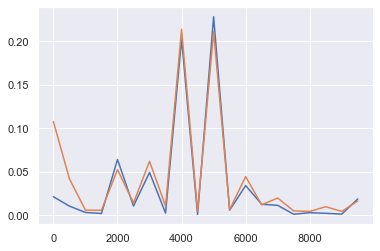

In [212]:
#построим кривые обучения
sns.lineplot(list(range(0,10000,500)),final_train)
sns.lineplot(list(range(0,10000,500)),history_valid)